# Point Cloud Identification

### Usage

#### Important global variables
- `chip_data` contains the complete data from the chip organised into tiles.
- `sorted_cells` contains all cell instances sorted by cell type.
- `cell_types` contains all the types of the cells
- `cell_box` contains representative box sizes for each cell type
- `representatives` contains representative via positions of a cell type

#### Important functions

- `get_aligned_vias(cell_type: str, num_cells : int = 100)` will return a list of all the vias of 100 cells of the given type and the calculated via count. Aligning the cells is very slow so for now I recommend only using up to a few thousand cells.
- `find_representative_vias(cell_type)` returns an array of a common via positioning for a given cell type

#### Cool functions
- `visualize_cells()` allows navigation and visualization of all cells by user input

### What I am trying to achieve:

Identifying cell types by using their via positions. Each cell is assigned a cell type; however, not all cells belong to the cell type they are assigned to. My goal is to find cells that differ too much from the cells of their own type and thus may be trojans. To do so, I will use the clustering approach from [Via_Clustering.ipynb] by Lukas Plätz to find representative via positions for each cell type. Then the cells will be compared to their representative type cells with different distance measures such as *Hausdorff, Chamfer, Earth Mover's, Jaccard, or Edit Distance*. I will evaluate the performance of each measure with the aim to find a measure that can robustely identify point clouds even when data is augmented.


## Imports

In [237]:
import re
import math
import json
import pickle
import numpy as np

from typing import Any
from numpy.typing import NDArray

from copy import deepcopy
from collections import Counter

from tqdm import tqdm
from scipy import stats
from matplotlib import pyplot as plt
plt.style.use('dark_background')


## Generate synthetic dataset

In [ ]:
# # Generating synthetic dataset of the same structure as the chip data with only 2 tiles, 10 cell types, each cell containing no more than 50 vias
# import random
# test_types = [f"TEST_TYPE{i+1}" for i in range(10)]
# test_type_boxes = {test_types[i-1] : ((0, 0), (100*i, 100*i)) for i in range(1, len(test_types)+1)}
# test_type_representatives = {test_types[i-1] : [(random.uniform(10, 80*i),random.uniform(10, 80*i)) for _ in range(2*i)] for i in range(1, len(test_types)+1)}


# def jitter_vias(vias, box, jitter_range=0.02):
#     (x_min, y_min), (x_max, y_max) = box
#     box_diagonal = ((x_max - x_min)**2 + (y_max - y_min)**2) ** 0.5
#     jitter_range = round(box_diagonal * jitter_range)
#     jittered = []
#     for x, y in vias:
#         new_x = min(max(x + random.randint(-jitter_range, jitter_range), x_min), x_max)
#         new_y = min(max(y + random.randint(-jitter_range, jitter_range), y_min), y_max)
#         jittered.append((new_x, new_y))
#     return jittered

# def delete_vias(vias, amount=0.25):
#     return random.sample(vias, len(vias) - round(len(vias) * amount))

# def add_vias(vias, box, amount=0.25):
#     (x_min, y_min), (x_max, y_max) = box
#     new_vias = [(random.randint(x_min, x_max), random.randint(y_min, y_max)) for _ in range(round(len(vias) * amount))]
#     return vias + new_vias

# test_cells = []
# for test_type in test_types:
#     box = test_type_boxes[test_type]
#     for i in range(500):
#         vias = test_type_representatives[test_type]
#         if i < 100:
#             vias = jitter_vias(vias, box)
#         elif i < 200:
#             vias = delete_vias(vias)
#         elif i < 300:
#             vias = add_vias(vias, box)
#         elif i < 350:
#             vias = jitter_vias(delete_vias(vias), box)
#         elif i < 400:
#             vias = add_vias(jitter_vias(vias, box), box)
#         elif i < 450:
#             vias = add_vias(delete_vias(vias), box)
#         else:
#             vias = jitter_vias(delete_vias(add_vias(vias, box)), box)
#         cell = {"box" : test_type_boxes[test_type],
#                 "data" : {'magnification': 0,
#                           'name': test_type,
#                           'reflection': False,
#                           'rotation': 0},
#                 "image" : f"image/{test_type}/{i}",
#                 "vias" : vias}
#         test_cells.append(cell)

# test_data = {"Test_tile_1" : test_cells[:2500], "Test_tile_2" : test_cells[2500:]}

In [ ]:
# with open("./Data/Test_Data.pickle", "wb") as f:
#     pickle.dump(test_data, f)
# with open("representatives_test_data.json", "w") as f:
#     json.dump(test_type_representatives, f)

## Load data

In [ ]:
datasets = {
    "28nm_chip" : { 'path' : './Data/Chip_Data_28nm.pickle', 'representatives' : 'representatives_28nm_chip.json' },
    "test_data" : { 'path' : './Data/Test_Data.pickle', 'representatives' : 'representatives_test_data.json'}}

dataset = "test_data"
chip_data_file = datasets[dataset]["path"]

chip_data = None
with open(chip_data_file, "rb") as f:
    chip_data = pickle.load(f)

tile_list = list(chip_data.keys())
all_cells = []
for tile in tile_list:
    all_cells += chip_data[tile]

sorted_cells = {}
for cell in all_cells:
    if cell["data"]["name"] not in sorted_cells.keys():
        sorted_cells[cell["data"]["name"]] = [cell]
    else:
        sorted_cells[cell["data"]["name"]].append(cell)

cell_types = list(sorted_cells.keys())

try:
    with open(datasets[dataset]["representatives"], "r") as f:
        representatives = json.load(f)
except FileNotFoundError:
    representatives = {}

## Utilities

### Cell Via utilities (From [Via_Clustering.ipynb])

In [4]:
def euk_dist_sq(p1 : tuple[int, int], p2 : tuple[int, int]) -> int:
    return pow(p1[0] - p2[0], 2) + pow(p1[1] - p2[1], 2)

def euk_dist(p1 : tuple[int, int], p2 : tuple[int, int]) -> float:
    return math.sqrt(euk_dist_sq(p1, p2))

def add_pts(p1 : tuple[int, int], p2 : tuple[int, int]) -> tuple[int, int]:
    return p1[0] + p2[0], p1[1] + p2[1]

def diff_pts(p1 : tuple[int, int], p2 : tuple[int, int]) -> tuple[int, int]:
    return p1[0] - p2[0], p1[1] - p2[1]

def rotate_cell_180(cell : dict[str, Any]) -> dict[str, Any]:
    cell = deepcopy(cell)
    box = cell["box"]
    box_width = box[1][0] - box[0][0]
    box_height = box[1][1] - box[0][1]
    # reflect y and reflect x == rotate 180
    cell["vias"] = [(v[0], box_height - v[1]) for v in cell["vias"]]
    cell["vias"] = [(box_width - v[0], v[1]) for v in cell["vias"]]
    return cell

def reflect_cell(cell : dict[str, Any], axis : str) -> dict[str, Any]:
    assert axis in ["Y", "X", "y", "x"], "Invalid axis given."
    cell = deepcopy(cell)
    box = cell["box"]
    box_width = box[1][0] - box[0][0]
    box_height = box[1][1] - box[0][1]
    if axis.lower() == "y":
        cell["vias"] = [(v[0], box_height - v[1]) for v in cell["vias"]] # powerline direction Y
    else:
        cell["vias"] = [(box_width - v[0], v[1]) for v in cell["vias"]] # powerline direction X_filtered
    return cell

def reset_transform(cell : dict[str, Any], powerline_direction : str) -> dict[str, Any]:
    """Transform the cell back to rotation = 0 and no reflection."""

    if cell["data"]["rotation"] == 180 and cell["data"]["reflection"]:
        return reflect_cell(cell, "x" if powerline_direction == "y" else "y")
    if cell["data"]["rotation"] == 180:
        return rotate_cell_180(cell)
    if cell["data"]["reflection"]:
        return reflect_cell(cell, powerline_direction)
    return cell

# try to match pts1 to pts2
def score_matching(pts1 : list[tuple[int, int]], pts2 : list[tuple[int, int]]) -> int:
    """Try to match the set of points 1 to points 2. The points of set 1 are matched to the closest
    point in set 2. The resulting score is the sum of the distances"""

    min_dists = []
    for p1 in pts1:
        dists = [euk_dist_sq(p1, p2) for p2 in pts2]
        min_dists.append(min(dists))
    return sum(min_dists)

def align_to_point(vias : list[tuple[int, int]], point : tuple[int, int]):
    return [diff_pts(point, v) for v in vias]

def align_cells(cell1_vias : list[tuple[int, int]], cell2_vias : list[tuple[int, int]], itr_count: int = 5):
    """ Given to sets of vias (points) try to align them as well as possible. For the optimal results all points
    would have to be tested but in all cases 5 works well enough. To use all points set itr_count to -1."""

    cell1, cell2 = deepcopy(cell1_vias), deepcopy(cell2_vias)
    min_scores = []

    for p1 in cell1[:itr_count]:
        # Set the chosen via in cell1 to (0, 0).
        p1_aligned_cell1 = align_to_point(cell1, p1)

        # Make a list where every point in cell2 is aligned to (0, 0) once.
        alignments_p2 = [(p2, align_to_point(cell2, p2)) for p2 in cell2]

        # Score all the alignments bettween cell1 and cell2
        fitting_scores = [(p1, p2, score_matching(c2, p1_aligned_cell1)) for p2, c2 in alignments_p2]

        min_scores.append(min(fitting_scores, key = lambda x : x[2]))
    p1_alignment, p2_alignment, score = min(min_scores, key = lambda x : x[2])
    aligned_cell1, aligned_cell2 = [diff_pts(p1, p1_alignment) for p1 in cell1], [diff_pts(p2, p2_alignment) for p2 in cell2]
    aligned_cell1, aligned_cell2 = [add_pts(p1, p1_alignment) for p1 in aligned_cell1], [add_pts(p2, p1_alignment) for p2 in aligned_cell2]
    return aligned_cell1, aligned_cell2

def get_aligned_vias(cell_type: str, num_cells : int = 100, alignment_itr : int = 7) -> tuple[int, np.array]:
    """Choose a cell type and get a list of all the aligned vias from a chosen number of instances."""
    # Transform all the cells to the same orientation
    cells = [reset_transform(c, "y") for c in sorted_cells[cell_type]]

    # Majority vote on the number of vias in the cell
    via_counter = Counter([len(cell["vias"]) for cell in cells])
    via_count = via_counter.most_common(1)[0][0]

    # Choose a good starting cell
    start_cell = None
    for i, cell in enumerate(cells):
        if len(cell["vias"]) == via_count:
            start_cell = cells.pop(i)
            break
    assert start_cell is not None, "Something went wrong. Start cell should not be None."

    # Extract all aligned vias from the cells
    all_vias = deepcopy(start_cell["vias"])
    for cell in cells[:num_cells]:
        _, vias_p2  = align_cells(start_cell["vias"], cell["vias"], itr_count=alignment_itr)
        all_vias += vias_p2
    return via_count, np.array(all_vias)

## Data Overview

### Scope of the data

In [249]:
cell_types_without_vias = [] # Assuming that if one cell of a type contains vias, all the other cells of same type also do
for type in cell_types:
    cells = sorted_cells[type]
    via = False
    for cell in tqdm(cells):
        if cell['vias'] != []:
            via = True
            break
    if not via: cell_types_without_vias.append(type)


  0%|          | 0/500 [00:00<?, ?it/s]


In [251]:
print("Total cell types:", len(cell_types))
print("Cell types that don't contain vias:", len(cell_types_without_vias))
print(cell_types_without_vias, '\n')

sum_all_cells = sum([len(sorted_cells[cell_type]) for cell_type in cell_types])
sum_no_via_cells = sum([len(sorted_cells[cell_type]) for cell_type in cell_types_without_vias])
print(f"Out of {sum_all_cells} total cells, {sum_all_cells - sum_no_via_cells} contain vias, meaning "
      "that only these cells can later be identified with the help of distance measures")

Total cell types: 10
Cell types that don't contain vias: 0
[] 

Out of 5000 total cells, 5000 contain vias, meaning that only these cells can later be identified with the help of distance measures


### Analyzing box sizes of cell types

In [252]:
# Count all box sizes of each cell type to see if and how much their sizes differ from each other
cell_boxes = {}
for cell_type in cell_types:
    cell_boxes[cell_type] = Counter()

    cells = sorted_cells[cell_type]
    for cell in cells:
        top_left, bottom_right = cell['box']
        box_size = (bottom_right[0] - top_left[0], bottom_right[1] - top_left[1])
        cell_boxes[cell_type][box_size] += 1

In [ ]:
# Find a cell type that contains the largest variations of box sizes
cell_type, max_boxes = None, []
for type, boxes in cell_boxes.items():
    if len(boxes) > len(max_boxes):
        cell_type, max_boxes = type, boxes

print(f"{cell_type} appears with {len(max_boxes)} different box sizes: {max_boxes}")

TEST_TYPE1 appears with 1 different box sizes: Counter({(100, 100): 500})


In [254]:
# Find cell types with the greatest height and width deviation
def deviation(l: list):
    return max(l) - min(l)

(cell_type_for_width, max_dev_width), (cell_type_for_height, max_dev_height) = (None, -1), (None, -1)
for type, boxes in cell_boxes.items():
    widths, heights = zip(*boxes)
    dev_width, dev_height = deviation(widths), deviation(heights)

    if dev_width > max_dev_width:
        cell_type_for_width = type
        max_dev_width = dev_width

    if dev_height > max_dev_height:
        cell_type_for_height = type
        max_dev_height = dev_height
    
print(f"One cell type with the greatest width deviation is {cell_type_for_width} with a deviation of {max_dev_width}")
print(f"One cell type with the greatest height deviation is {cell_type_for_height} with a deviation of {max_dev_height}")

One cell type with the greatest width deviation is TEST_TYPE1 with a deviation of 0
One cell type with the greatest height deviation is TEST_TYPE1 with a deviation of 0


In [10]:
# => All boxes of a specific cell type are effectively the same size, with negligible deviations most likely caused by image resolution and processing errors
# This is important for normalizing the distance measures later

In [255]:
# Choose the biggest cell box for each cell as a representative box for that cell
cell_box = {}
for type, boxes in cell_boxes.items():
    widths, heights = zip(*boxes)
    cell_box[type] = (max(widths), max(heights))

## Choosing representative vias per cell type

In [12]:
# I will first use the Bayesian Gaussian Mixture Model (BGMM), used in [Via_Clustering], to cluster common via positions per cell type
# These via positions will later represent a "perfect" cell of a specific type to which other cells will be compared to
# Based on the similarity between these cells, we will decide which of the cells might be mislabeled (trojans)

In [13]:
from sklearn.mixture import BayesianGaussianMixture

def find_representative_vias(cell_type) -> NDArray[np.float64]:
    via_count, cell_vias = get_aligned_vias(cell_type, num_cells=1000)
    lose_upper_bound = int(via_count*(1.5))
    lose_lower_bound_weights = (1)/lose_upper_bound

    bgmm = BayesianGaussianMixture(
        n_components=lose_upper_bound,
        covariance_type='spherical',
        mean_precision_prior=.001,
    )
    bgmm.fit(cell_vias)

    predicted_via_clusters = bgmm.predict(cell_vias)
    predicted_via_clusters[bgmm.weights_[predicted_via_clusters] < lose_lower_bound_weights] = -1

    means = bgmm.means_[bgmm.weights_ > lose_lower_bound_weights]
    
    plt.scatter(*cell_vias.T, c=predicted_via_clusters, alpha=0.1)
    plt.scatter(means[:, 0], means[:, 1], marker='x', c='r')
    plt.show()
    return np.array(means)

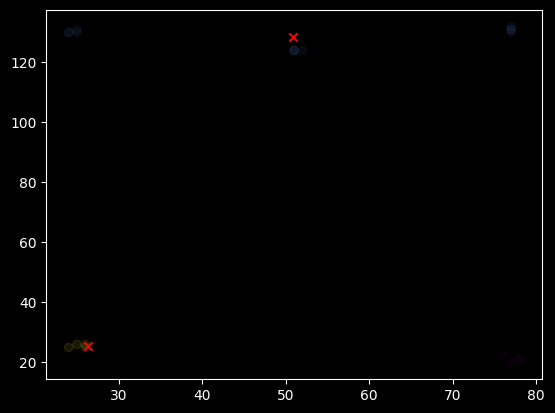

array([[ 50.9166771, 128.4131551],
       [ 26.2813634,  25.4270259]])

In [14]:
find_representative_vias('AES')

In [ ]:
# Well well well, BGMM does not perform as expected... switching to kmeans with clearing outliers to improve precision of the representative via positions
# This approach is also heavily based on the code by Lukas Plätz [Via_Clustering.ipynb]
from sklearn.cluster import KMeans

def find_representative_vias(cell_type, plot=False) -> NDArray:
    via_count, cell_vias = get_aligned_vias(cell_type, num_cells=15)
    print(via_count)
    filtered_vias = deepcopy(cell_vias)

    kmeans = KMeans(n_clusters=via_count)
    kmeans.fit(cell_vias)

    sigma_old = 100
    sigma = 0

    while sigma_old != sigma:
        labels = kmeans.labels_

        distances = np.zeros(len(filtered_vias))
        for i in range(len(filtered_vias)):
            cluster_center = kmeans.cluster_centers_[labels[i]]
            distances[i] = np.linalg.norm(filtered_vias[i] - cluster_center)

        sigma_old = sigma
        _, sigma = stats.halfnorm.fit(distances) # If the distances are normal distributed then the absolute vales are halfnormal distributed
        
        if sigma == sigma_old:
            break

        normal_distributed = stats.gzscore(distances + np.finfo(float).eps, nan_policy='omit')

        # Find points within threshold
        is_inlier_n = normal_distributed <= 3
        filtered_vias = filtered_vias[is_inlier_n]  # Filter option can be adapted

        kmeans.fit(filtered_vias)
    
    means = kmeans.cluster_centers_

    if plot:
        predicted_via_clusters = kmeans.predict(cell_vias)
        plt.scatter(*zip(*cell_vias), c=predicted_via_clusters, alpha=0.3)
        plt.scatter(*zip(*means), marker='x', c='r')

    return means

15


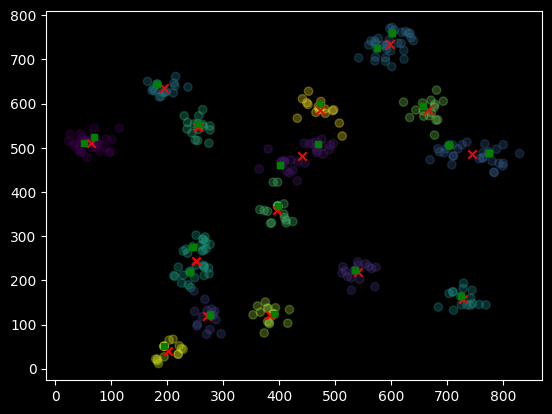

In [ ]:
find_representative_vias('TEST_TYPE10', plot=True)
plt.scatter(*zip(*representatives['TEST_TYPE10']), marker='s', s=20, c='green')
# Looks much better....

In [ ]:
# Extend representatives if needed
extension = 0
for type in tqdm(cell_types[len(representatives) : len(representatives) + extension]):
    print(type)
    representatives[type] = [[],[]] if type in cell_types_without_vias else find_representative_vias(type).tolist()

# Save extension in the json file
with open(datasets[dataset]["representatives"], "w") as f:
    json.dump(representatives, f)

  0%|          | 0/50 [00:00<?, ?it/s]

AZO


  2%|▏         | 1/50 [00:00<00:42,  1.17it/s]

AXK


  4%|▍         | 2/50 [00:01<00:39,  1.21it/s]

AZE


 10%|█         | 5/50 [00:02<00:15,  2.95it/s]

LS
BFC
BEI


 16%|█▌        | 8/50 [00:08<00:49,  1.19s/it]

BEE
BDS
AGE
ATW


 26%|██▌       | 13/50 [00:09<00:16,  2.28it/s]

AFW
AFU
ATM
AUA


 32%|███▏      | 16/50 [00:09<00:11,  3.02it/s]

AFO
BCQ
ASK


 36%|███▌      | 18/50 [00:10<00:08,  3.69it/s]

BCM


 40%|████      | 20/50 [00:10<00:05,  5.13it/s]

AFK
AJK
AFM
ATK
AOA


 46%|████▌     | 23/50 [00:10<00:04,  5.83it/s]

ANG


 50%|█████     | 25/50 [00:11<00:04,  5.39it/s]

AEG
AWE


 56%|█████▌    | 28/50 [00:11<00:02,  7.41it/s]

GK
AWI
BC


 58%|█████▊    | 29/50 [00:11<00:03,  5.96it/s]

ASI


 60%|██████    | 30/50 [00:12<00:04,  4.01it/s]

AXI


 62%|██████▏   | 31/50 [00:13<00:06,  3.00it/s]

ASC


 66%|██████▌   | 33/50 [02:34<07:18, 25.81s/it]

BFA
BEQ


 68%|██████▊   | 34/50 [02:34<05:02, 18.88s/it]

BDO


 72%|███████▏  | 36/50 [02:34<02:18,  9.88s/it]

BCW
BDK


 76%|███████▌  | 38/50 [02:35<01:01,  5.11s/it]

BDC
BCU


 78%|███████▊  | 39/50 [02:35<00:40,  3.68s/it]

BCI
BCK


 82%|████████▏ | 41/50 [02:36<00:20,  2.24s/it]

BCC
AXC


 86%|████████▌ | 43/50 [02:37<00:10,  1.44s/it]

ARW


 88%|████████▊ | 44/50 [02:37<00:07,  1.23s/it]

ANO
AQM


 94%|█████████▍| 47/50 [02:38<00:02,  1.40it/s]

APK
AFY
AUK


 98%|█████████▊| 49/50 [02:42<00:01,  1.29s/it]

AYA


100%|██████████| 50/50 [02:44<00:00,  3.29s/it]


In [264]:
print(len(representatives))
print(representatives)

10
{'TEST_TYPE1': [[60.74094212626994, 26.00235268518256], [65.5860461539286, 51.319849568464946]], 'TEST_TYPE2': [[80.17976955454162, 153.44147038022652], [10.294267720574403, 15.693861848453896], [131.10209937466126, 26.783514052815303], [111.47108767409088, 78.00793491639651]], 'TEST_TYPE3': [[218.20065477602722, 72.87459659881713], [213.69194072432984, 185.573730752994], [38.55731892268324, 64.09033912044632], [198.26437527252563, 20.47177286064003], [117.01438868515183, 84.1698509388479], [105.09282362632149, 24.644706881575132]], 'TEST_TYPE4': [[30.338534239614916, 166.51983860643307], [13.222370428610613, 149.17580725910491], [31.995787425381618, 300.6100970270948], [30.49606429111209, 285.48242056948664], [54.072015927322646, 238.90471781460218], [152.89817773281902, 195.9878909695906], [80.17299020444938, 125.91994230787427], [186.03756687416592, 155.9857741104468]], 'TEST_TYPE5': [[156.10836650923167, 16.24294379753149], [89.99961811059403, 129.48382025880358], [378.389276555

## Visualizing vias in boxes

In [256]:
from matplotlib.patches import Rectangle
from IPython.display import display, clear_output

In [260]:
def display_cell(cursor, subcursor, fig, ax):
    cell_type = cell_types[cursor]
    cell = reset_transform(sorted_cells[cell_type][subcursor], "y")
    box = cell_box[cell_type]
    vias = zip(*cell['vias']) if cell['vias'] != [] else ([], [])
    representative = zip(*representatives[cell_type])\
        if cell_type in representatives and representatives[cell_type] != [[],[]]\
        else ([], [])
    
    ax.clear()
    ax.set_title(f"{cell_type} ({cursor + 1}/{len(sorted_cells)}) ({subcursor + 1}/{len(sorted_cells[cell_type])})")
    ax.set_xlim(-0.25*box[0], 1.25*box[0])
    ax.set_ylim(-0.25*box[1], 1.25*box[1])
    ax.add_patch(Rectangle((0, 0), box[0], box[1], edgecolor='yellow', facecolor='none'))
    ax.scatter(*representative, s=5, color='green')
    ax.scatter(*vias, s=1, color='red')
    display(fig)
    clear_output(wait=True)


In [265]:
def visualize_cells():    
    fig, ax = plt.subplots()

    cursor = 0
    subcursor = 0

    allowed_inputs = {'enter' : '',
                    'next' : 'n',
                    'prev' : 'p',
                    'jump' : r'\d+',
                    'next_cell' : r'c\+',
                    'prev_cell' : r'c\-',
                    'jump_cell' : r'c\d+',
                    'quit' : 'q'}

    n = len(cell_types)
    last_command = allowed_inputs['enter']

    while True:
        m = len(sorted_cells[cell_types[cursor]])
        cursor %= n # type: ignore
        subcursor %= m

        print("""
Commands:
- [Enter]       | Repeat last command
- n             | Next cell type
- p             | Previous cell type
- [Cell Type]   | Jump to specific cell type by name
- [Number]      | Jump to specific cell type by index
- c+            | Next cell instance within type
- c-            | Previous cell instance within type
- c[Number]     | Jump to specific cell instance (e.g., c5)
- q             | Quit
___________________________________________________________

Legend:
- Green points  | Cell type representative vias
- Red points    | Vias of the actual cell
        """)

        display_cell(cursor, subcursor, fig, ax)
        
        key = input("Enter a command")
        
        if key == allowed_inputs['enter']:
            key = last_command

        if re.fullmatch(allowed_inputs['next'], key):
            cursor += 1
        elif re.fullmatch(allowed_inputs['prev'], key):
            cursor -= 1
        elif re.fullmatch(allowed_inputs['jump'], key):
            cursor = int(key) - 1
        elif re.fullmatch(allowed_inputs['next_cell'], key):
            subcursor += 1
        elif re.fullmatch(allowed_inputs['prev_cell'], key):
            subcursor -= 1
        elif re.fullmatch(allowed_inputs['jump_cell'], key):
            subcursor = int(key[1:]) - 1
        elif key in sorted_cells:
            cursor = cell_types.index(key)
        elif re.fullmatch(allowed_inputs['quit'], key):
            break
        else:
            key = allowed_inputs['enter']
        
        last_command = key

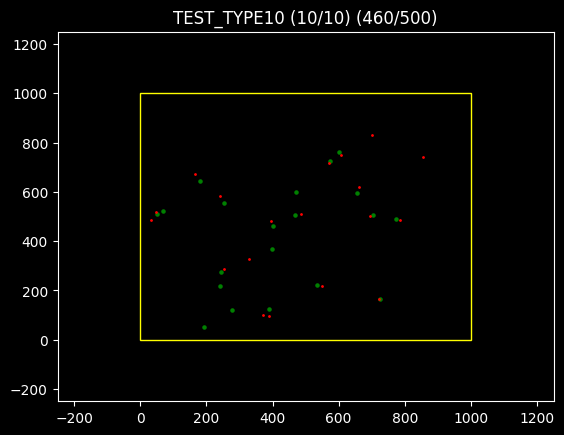

In [262]:
visualize_cells()

## Identification of point clouds via distance measures

### Earth Mover's Distance (EMD)